<a href="https://colab.research.google.com/github/Shreya-516/XAI-ECG/blob/main/XAI-ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import zipfile
import os


zip_path = "/content/mit-bih-arrhythmia-database-1.0.0.zip"
extract_to = "/content/mitdb"


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Extraction complete!")
files = os.listdir("/content/mitdb")
print("📂 Extracted files:", files[:10])
records = sorted(set(f.split('.')[0] for f in os.listdir("/content/mitdb") if f.endswith('.hea')))
print("✅ Available records:", records)



✅ Extraction complete!
📂 Extracted files: ['mit-bih-arrhythmia-database-1.0.0']
✅ Available records: []


In [3]:
!pip install wfdb biosppy peakutils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 97.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


Epoch 1/3
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.7695 - loss: 0.5304 - val_accuracy: 0.8550 - val_loss: 0.3831
Epoch 2/3
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.8600 - loss: 0.3589 - val_accuracy: 0.8850 - val_loss: 0.3103
Epoch 3/3
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.8859 - loss: 0.2878 - val_accuracy: 0.9300 - val_loss: 0.2040


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9247 - loss: 0.2166

Test Accuracy: 0.9300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step



Classification Report:
               precision    recall  f1-score   support

      Normal       0.95      0.94      0.94       751
  Arrhythmia       0.90      0.92      0.91       449

    accuracy                           0.93      1200
   macro avg       0.92      0.93      0.93      1200
weighted avg       0.93      0.93      0.93      1200

Confusion Matrix:
 [[704  47]
 [ 37 412]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


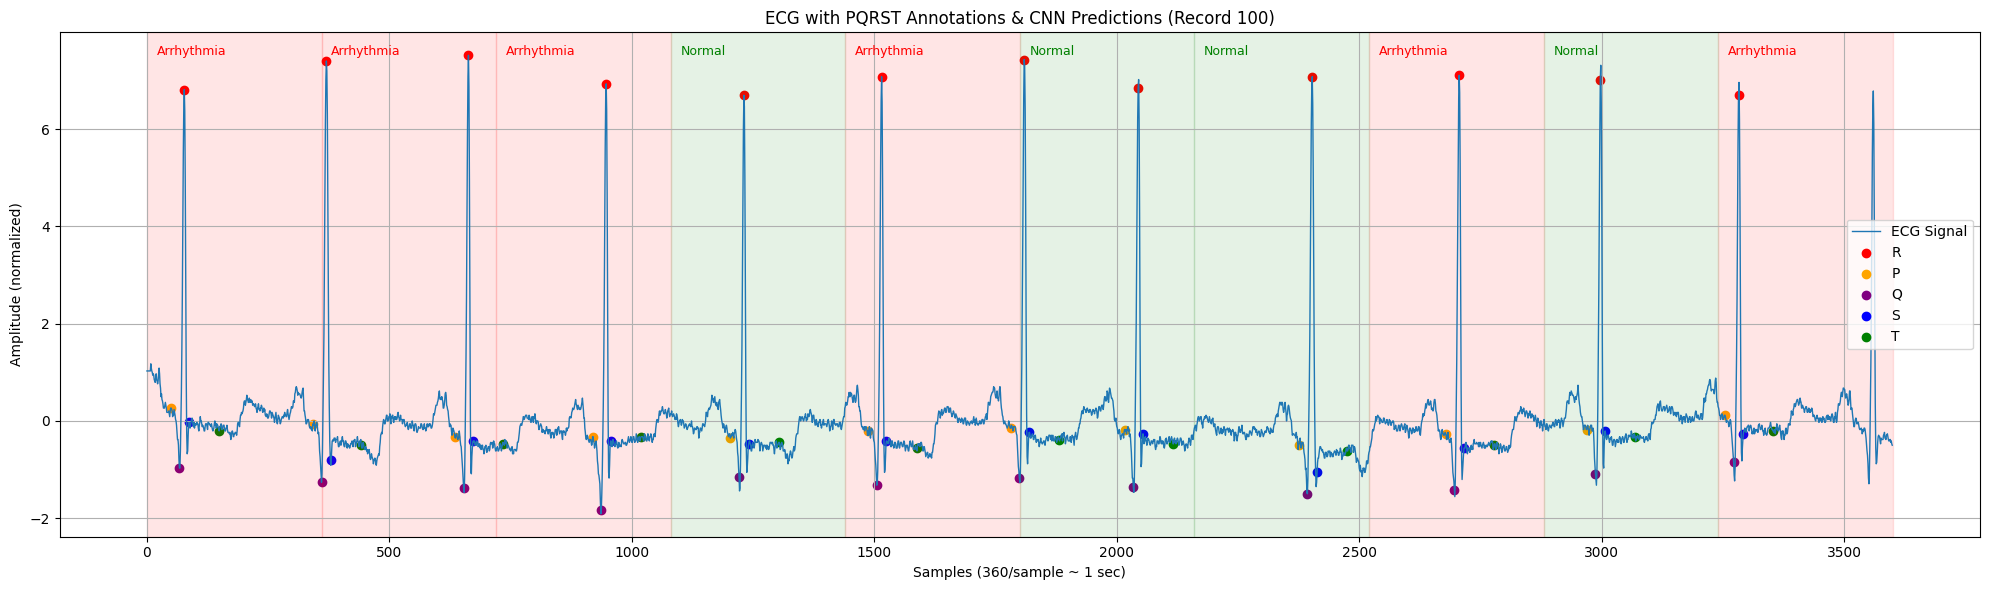

Summary for Record 100:
Normal segments: 4
Arrhythmia segments: 6

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


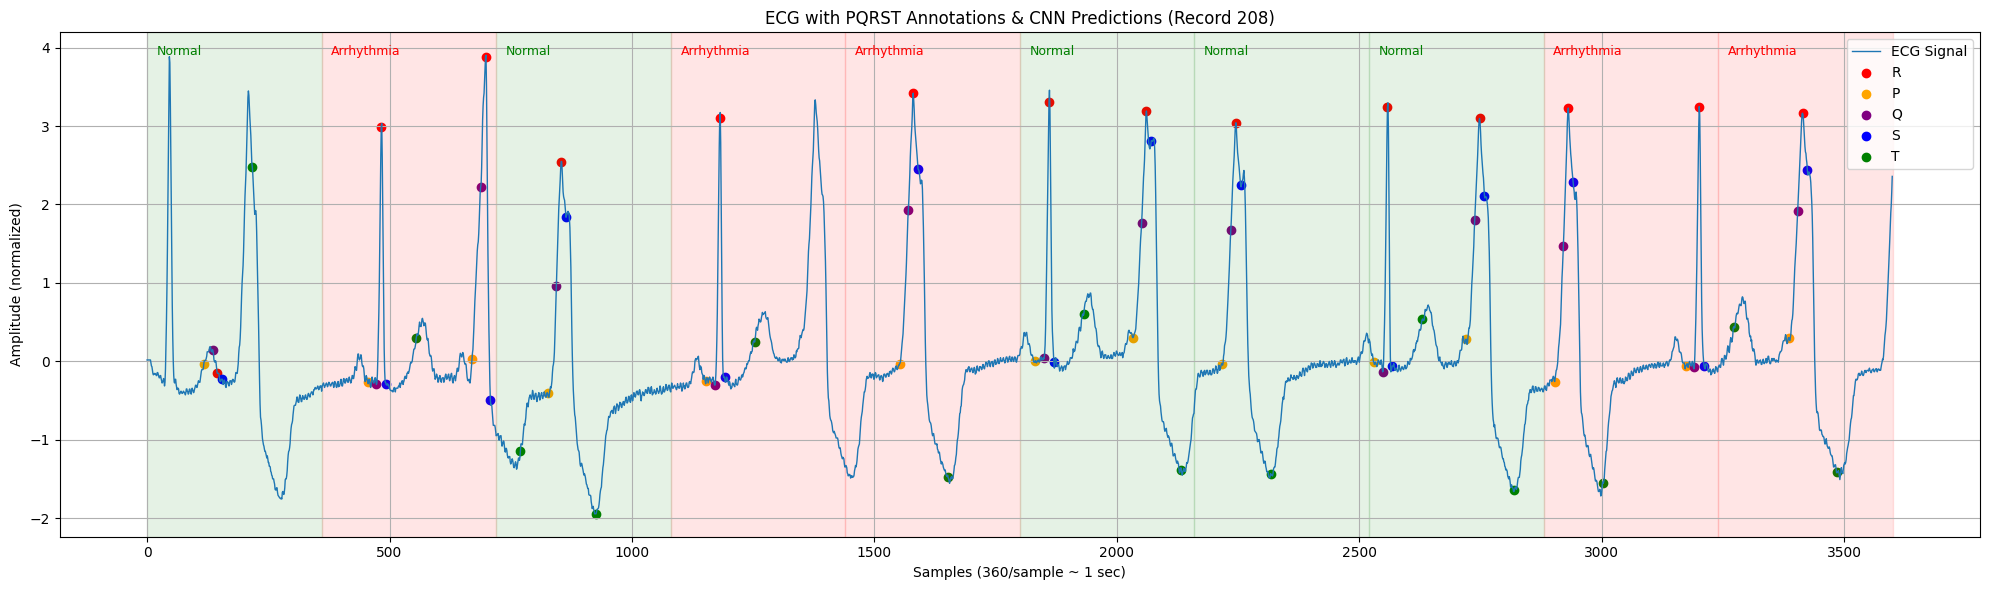

Summary for Record 208:
Normal segments: 5
Arrhythmia segments: 5



In [4]:
import numpy as np
import pandas as pd
import wfdb
import os
import matplotlib.pyplot as plt
from biosppy.signals import ecg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, LSTM, Dense

records = ['100', '104', '105', '207', '208']
data_segments = []
labels = []
segment_len = 360

for record_name in records:
    record_path = f"/content/mitdb/mit-bih-arrhythmia-database-1.0.0/{record_name}"
    ann = wfdb.rdann(record_path, 'atr')
    record = wfdb.rdrecord(record_path, channels=[0])
    sig = record.p_signal.flatten()
    beat_annots = ann.sample
    beat_labels = ann.symbol
    fs = record.fs

    for i in range(len(beat_annots)):
        center = beat_annots[i]
        if center - segment_len//2 < 0 or center + segment_len//2 >= len(sig):
            continue
        segment = sig[center - segment_len//2 : center + segment_len//2]
        label = 0 if beat_labels[i] == 'N' else 1
        data_segments.append(segment)
        labels.append(label)

X = np.array(data_segments)
y = np.array(labels)
X = X[:6000]
y = y[:6000]

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape(-1, segment_len, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = Sequential([
    Input(shape=(segment_len, 1)),
    Conv1D(32, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))
model.save("ecg_cnn_model.h5")

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
y_pred = np.argmax(model.predict(X_test), axis=1)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Normal', 'Arrhythmia']))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

def plot_ecg(record_id, title):
    record = wfdb.rdrecord(f'/content/mitdb/mit-bih-arrhythmia-database-1.0.0/{record_id}', channels=[0])
    ann = wfdb.rdann(f'/content/mitdb/mit-bih-arrhythmia-database-1.0.0/{record_id}', 'atr')
    signal = record.p_signal.flatten()
    fs = record.fs
    samples = signal[:3600]
    scaler = StandardScaler()
    samples = scaler.fit_transform(samples.reshape(-1, 1)).flatten()
    X_segments = []
    for i in range(0, len(samples), segment_len):
        chunk = samples[i:i+segment_len]
        if len(chunk) == segment_len:
            X_segments.append(chunk)
    X_segments = np.array(X_segments).reshape(-1, segment_len, 1)
    model = load_model("ecg_cnn_model.h5")
    preds = model.predict(X_segments)
    pred_labels = np.argmax(preds, axis=1)
    out = ecg.ecg(signal=samples, sampling_rate=fs, show=False)
    rpeaks = out['rpeaks']
    plt.figure(figsize=(20, 6))
    plt.plot(samples, label='ECG Signal', linewidth=1)
    plt.scatter(rpeaks, samples[rpeaks], c='red', label='R')
    p_locs = rpeaks - int(0.08 * fs)
    q_locs = rpeaks - int(0.03 * fs)
    s_locs = rpeaks + int(0.03 * fs)
    t_locs = rpeaks + int(0.2 * fs)
    valid = lambda locs: locs[(locs > 0) & (locs < len(samples))]
    plt.scatter(valid(p_locs), samples[valid(p_locs)], c='orange', label='P')
    plt.scatter(valid(q_locs), samples[valid(q_locs)], c='purple', label='Q')
    plt.scatter(valid(s_locs), samples[valid(s_locs)], c='blue', label='S')
    plt.scatter(valid(t_locs), samples[valid(t_locs)], c='green', label='T')
    normal_count = 0
    arr_count = 0
    for i, label in enumerate(pred_labels):
        color = 'green' if label == 0 else 'red'
        label_text = "Normal" if label == 0 else "Arrhythmia"
        plt.axvspan(i * segment_len, (i + 1) * segment_len, color=color, alpha=0.1)
        if label == 0:
            normal_count += 1
        else:
            arr_count += 1
        plt.text(i * segment_len + 20, max(samples), label_text, color=color, fontsize=9)
    plt.title(title)
    plt.xlabel("Samples (360/sample ~ 1 sec)")
    plt.ylabel("Amplitude (normalized)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print(f"Summary for Record {record_id}:")
    print(f"Normal segments: {normal_count}")
    print(f"Arrhythmia segments: {arr_count}\n")

plot_ecg('100', "ECG with PQRST Annotations & CNN Predictions (Record 100)")
plot_ecg('208', "ECG with PQRST Annotations & CNN Predictions (Record 208)")


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - accuracy: 0.9040 - loss: 0.5725 - val_accuracy: 0.9765 - val_loss: 0.1218
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.9784 - loss: 0.1137 - val_accuracy: 0.9765 - val_loss: 0.1198
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.9752 - loss: 0.1289 - val_accuracy: 0.9765 - val_loss: 0.1231
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.9751 - loss: 0.1288 - val_accuracy: 0.9765 - val_loss: 0.1166
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9755 - loss: 0.1237 - val_accuracy: 0.9765 - val_loss: 0.1169


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9738 - loss: 0.1249

Test Accuracy: 0.9765
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step

Classification Report:
               precision    recall  f1-score   support

           N       0.98      1.00      0.99      1953
           L       0.00      0.00      0.00         0
           R       0.00      0.00      0.00         0
           V       0.00      0.00      0.00        39
           A       0.00      0.00      0.00         8

    accuracy                           0.98      2000
   macro avg       0.20      0.20      0.20      2000
weighted avg       0.95      0.98      0.96      2000

Confusion Matrix:
 [[1953    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [  39    0    0    0    0]
 [   8    0    0    0    0]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


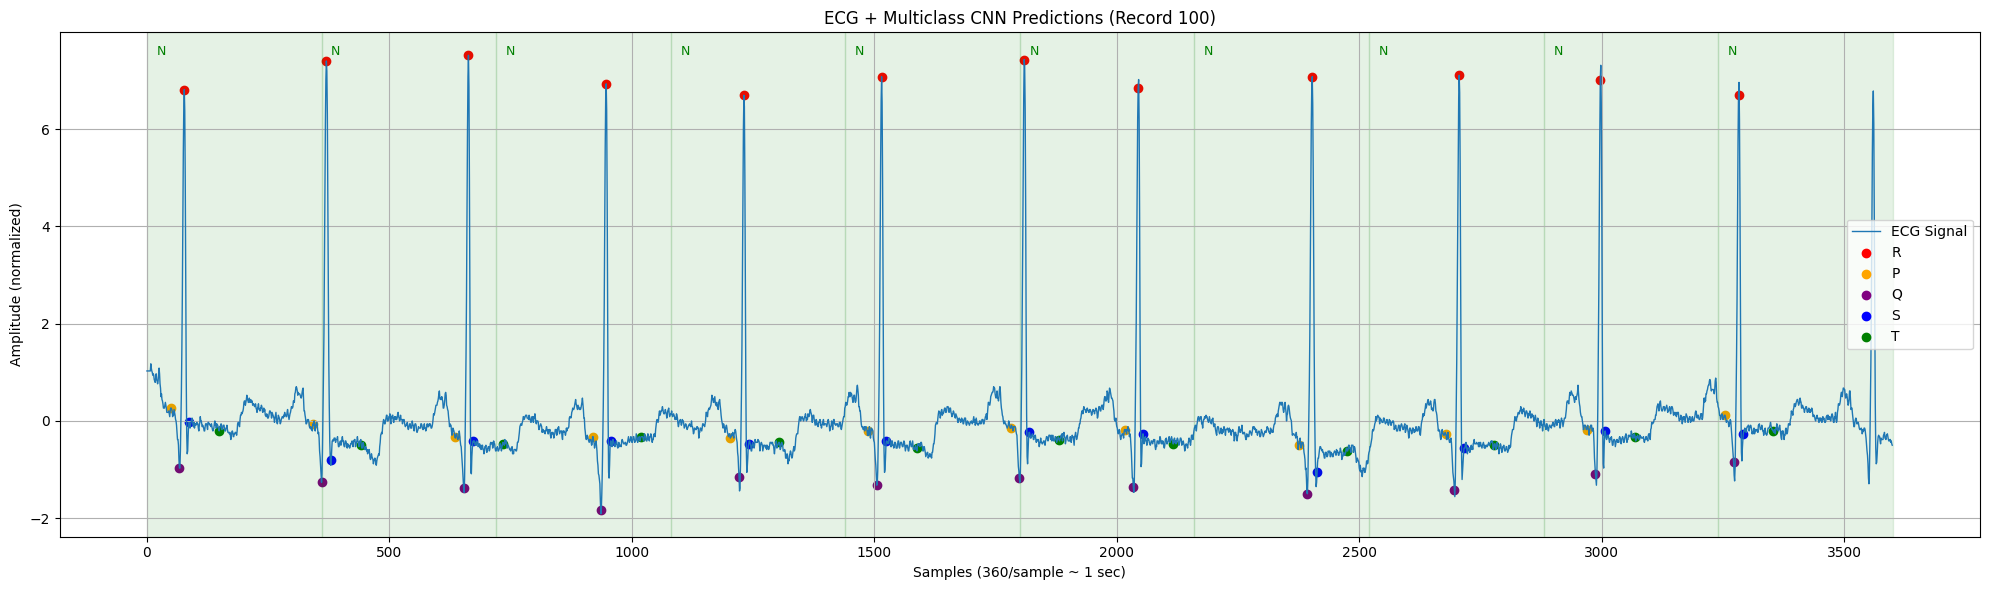

Summary for Record 100:
N segments: 10
L segments: 0
R segments: 0
V segments: 0
A segments: 0


In [ ]:
# FINAL CODE
import numpy as np
import pandas as pd
import wfdb
import os
import matplotlib.pyplot as plt
from biosppy.signals import ecg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, LSTM, Dense

# Include more records to balance rare classes
records = [
    '100', '101', '102', '103', '104', '105', '106', '107',
    '108', '109', '111', '112', '113', '114', '115', '116',
    '117', '118', '119', '121', '122', '123', '124', '200',
    '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234'
]

# Label mapping
label_map = {'N': 0, 'L': 1, 'R': 2, 'V': 3, 'A': 4}
data_segments = []
labels = []
segment_len = 360

# Load and label data
for record_name in records:
    try:
        record_path = f"/content/mitdb/mit-bih-arrhythmia-database-1.0.0/{record_name}"
        ann = wfdb.rdann(record_path, 'atr')
        record = wfdb.rdrecord(record_path, channels=[0])
        sig = record.p_signal.flatten()
        beat_annots = ann.sample
        beat_labels = ann.symbol
        fs = record.fs

        for i in range(len(beat_annots)):
            center = beat_annots[i]
            if center - segment_len//2 < 0 or center + segment_len//2 >= len(sig):
                continue
            segment = sig[center - segment_len//2 : center + segment_len//2]
            label = label_map.get(beat_labels[i])
            if label is not None:
                data_segments.append(segment)
                labels.append(label)
    except Exception as e:
        print(f"Error loading record {record_name}: {e}")

# Prepare data
X = np.array(data_segments)
y = np.array(labels)

# Balance down for quick training/testing
max_samples = 10000
X = X[:max_samples]
y = y[:max_samples]

# Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape(-1, segment_len, 1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# CNN + LSTM Model
model = Sequential([
    Input(shape=(segment_len, 1)),
    Conv1D(32, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Save model
model.save("ecg_cnn_multiclass_model.h5")

# Evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
y_pred = np.argmax(model.predict(X_test), axis=1)
class_names = ['N', 'L', 'R', 'V', 'A']
class_ids = [0, 1, 2, 3, 4]

print("\nClassification Report:\n", classification_report(
    y_test, y_pred, labels=class_ids, target_names=class_names, zero_division=0
))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=class_ids))


# Visualization Function
def plot_ecg(record_id, title):
    record = wfdb.rdrecord(f'/content/mitdb/mit-bih-arrhythmia-database-1.0.0/{record_id}', channels=[0])
    ann = wfdb.rdann(f'/content/mitdb/mit-bih-arrhythmia-database-1.0.0/{record_id}', 'atr')
    signal = record.p_signal.flatten()
    fs = record.fs
    samples = signal[:3600]
    scaler = StandardScaler()
    samples = scaler.fit_transform(samples.reshape(-1, 1)).flatten()
    X_segments = []
    for i in range(0, len(samples), segment_len):
        chunk = samples[i:i+segment_len]
        if len(chunk) == segment_len:
            X_segments.append(chunk)
    X_segments = np.array(X_segments).reshape(-1, segment_len, 1)
    model = load_model("ecg_cnn_multiclass_model.h5")
    preds = model.predict(X_segments)
    pred_labels = np.argmax(preds, axis=1)

    out = ecg.ecg(signal=samples, sampling_rate=fs, show=False)
    rpeaks = out['rpeaks']
    plt.figure(figsize=(20, 6))
    plt.plot(samples, label='ECG Signal', linewidth=1)
    plt.scatter(rpeaks, samples[rpeaks], c='red', label='R')

    # PQRST Annotations
    p_locs = rpeaks - int(0.08 * fs)
    q_locs = rpeaks - int(0.03 * fs)
    s_locs = rpeaks + int(0.03 * fs)
    t_locs = rpeaks + int(0.2 * fs)
    valid = lambda locs: locs[(locs > 0) & (locs < len(samples))]
    plt.scatter(valid(p_locs), samples[valid(p_locs)], c='orange', label='P')
    plt.scatter(valid(q_locs), samples[valid(q_locs)], c='purple', label='Q')
    plt.scatter(valid(s_locs), samples[valid(s_locs)], c='blue', label='S')
    plt.scatter(valid(t_locs), samples[valid(t_locs)], c='green', label='T')

    # Color-coded segments
    class_colors = {0: 'green', 1: 'orange', 2: 'blue', 3: 'red', 4: 'purple'}
    class_labels = {0: 'N', 1: 'L', 2: 'R', 3: 'V', 4: 'A'}
    class_counts = {i: 0 for i in range(5)}
    for i, label in enumerate(pred_labels):
        plt.axvspan(i * segment_len, (i + 1) * segment_len, color=class_colors[label], alpha=0.1)
        class_counts[label] += 1
        plt.text(i * segment_len + 20, max(samples), class_labels[label], color=class_colors[label], fontsize=9)

    plt.title(title)
    plt.xlabel("Samples (360/sample ~ 1 sec)")
    plt.ylabel("Amplitude (normalized)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Summary for Record {record_id}:")
    for cls in class_counts:
        print(f"{class_labels[cls]} segments: {class_counts[cls]}")

# Visualize
plot_ecg('100', "ECG + Multiclass CNN Predictions (Record 100)")


In [ ]:
pip install wfdb


In [ ]:
import wfdb
wfdb.dl_database('mitdb', dl_dir='mit-bih-arrhythmia-database-1.0.0')


Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [ ]:
segment_len = 360  # Set this correctly BEFORE using it

data_segments = []
labels = []

for record_name in records:
    try:
        record_path = f"/content/mitdb/mit-bih-arrhythmia-database-1.0.0/{record_name}"
        ann = wfdb.rdann(record_path, 'atr')
        record = wfdb.rdrecord(record_path, channels=[0])
        sig = record.p_signal.flatten()
        beat_annots = ann.sample
        beat_labels = ann.symbol
        fs = record.fs

        for i in range(len(beat_annots)):
            center = beat_annots[i]
            start = center - segment_len // 2
            end = center + segment_len // 2

            if start < 0 or end >= len(sig):
                continue

            segment = sig[start:end]
            if len(segment) == segment_len:
                label = label_map.get(beat_labels[i])
                if label is not None:
                    data_segments.append(segment)
                    labels.append(label)
    except Exception as e:
        print(f"Error with record {record_name}: {e}")


In [ ]:
# Convert to numpy arrays
X = np.array(data_segments)
y = np.array(labels)

# Optional: Limit for speed
max_samples = 20000
X = X[:max_samples]
y = y[:max_samples]

# Normalize & reshape
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape(-1, 360, 1)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
print(X_test.shape)  # ✅ Should now show (n, 360, 1)
print({x.shape for x in X_test})  # ✅ Should be {(360, 1)}


(4000, 360, 1)
{(360, 1)}
